In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

import gc  # Garbage Collector zur Speicherverwaltung
import sys
import os
sys.path.append(os.path.abspath("../.."))

from utils.scatter_plot import scatter_prediction
from utils.eval_call import evaluate_model

from Preprocessing.imputation import get_imputation_maps, apply_imputation,ContextImputer

from Preprocessing.superSimple_preprocessing_pipeline import preprocessing_pipeline
from Preprocessing.LrFilter_preprocessing import preprocessing_pipeline_lrfilter

from Preprocessing.preprocessing_pipeline_segment import preprocessing_pipeline_segment
from Preprocessing.split import split_data


In [3]:
df = preprocessing_pipeline('../../data.csv')


In [4]:

df = df.drop(columns=["offer_description"])
df

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,registration_month
0,alfa-romeo,Alfa Romeo GTV,red,1995-10-01,1995,1300,148.0,201.0,Manual,Petrol,10.9,260.0,160500.0,10
1,alfa-romeo,Alfa Romeo 164,black,1995-02-01,1995,24900,191.0,260.0,Manual,Petrol,NaN,NaN,190000.0,2
2,alfa-romeo,Alfa Romeo Spider,black,1995-02-01,1995,5900,110.0,150.0,Unknown,Petrol,NaN,NaN,129000.0,2
3,alfa-romeo,Alfa Romeo Spider,black,1995-07-01,1995,4900,110.0,150.0,Manual,Petrol,9.5,225.0,189500.0,7
4,alfa-romeo,Alfa Romeo 164,red,1996-11-01,1996,17950,132.0,179.0,Manual,Petrol,7.2,NaN,96127.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229696,volvo,Volvo V90 Cross Country,silver,2023-01-01,2023,65422,145.0,197.0,Automatic,Diesel,6.5,170.0,1506.0,1
229697,volvo,Volvo XC60,silver,2023-05-01,2023,55400,145.0,197.0,Automatic,Diesel,5.6,142.0,5000.0,5
229698,volvo,Volvo XC60,silver,2023-03-01,2023,54500,145.0,197.0,Automatic,Diesel,5.6,142.0,5900.0,3
229699,volvo,Volvo XC90,white,2023-03-01,2023,89690,173.0,235.0,Automatic,Diesel,7.6,202.0,4900.0,3


In [5]:
df = preprocessing_pipeline('../../data.csv')

df["age"] = 2023 - df["year"]
df = df.drop(columns=["offer_description"])

X_train, X_test, y_train, y_test , X,y, categorical_features , numeric_features = split_data(df)

numeric_features.remove('fuel_consumption_g_km')
numeric_features.remove('power_kw')
numeric_features.remove('year')

X_test = X_test.drop(columns=['power_kw','fuel_consumption_g_km',"fuel_consumption_g_km","year","registration_date","registration_month"])
df = preprocessing_pipeline_lrfilter(X_train,y_train)
X_train = df.drop(columns=['price_in_euro'])
y_train = df['price_in_euro']

print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)


(178899,)
(45941,)
(178899, 9)
(45941, 9)



Training KNN model ...
KNN Regression Performance Metrics:
MAE: 3852.81
MSE: 156644592.29
RMSE: 12515.77
R²: 0.86
------------------------------


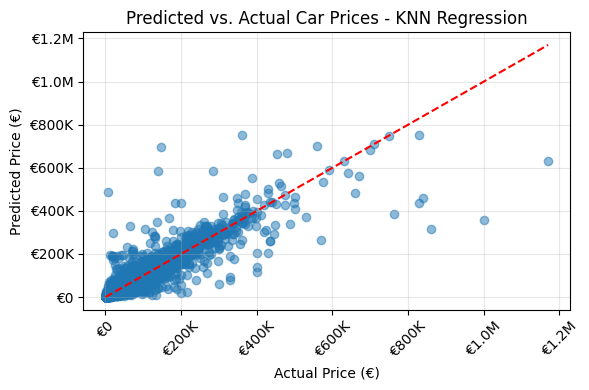

In [6]:
def main():
    df = preprocessing_pipeline('../../data.csv')

    df["age"] = 2023 - df["year"]
    df = df.drop(columns=["offer_description"])

    X_train, X_test, y_train, y_test , X,y, categorical_features , numeric_features = split_data(df)

    numeric_features.remove('fuel_consumption_g_km')
    numeric_features.remove('power_kw')
    numeric_features.remove('year')

    X_test = X_test.drop(columns=['power_kw','fuel_consumption_g_km',"fuel_consumption_g_km","year","registration_date","registration_month"])
    df = preprocessing_pipeline_lrfilter(X_train,y_train)
    X_train = df.drop(columns=['price_in_euro'])
    y_train = df['price_in_euro']

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())  # Scaling is crucial for KNN
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])



    final_knn_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsRegressor(
            n_neighbors=4,
            weights='distance',  
            algorithm='auto',
            p = 2, #Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.
            n_jobs=-1  
        ))
    ])


    print("\nTraining KNN model ...")
    final_knn_pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred_knn = final_knn_pipeline.predict(X_test)

    # Evaluate model
    evaluate_model(y_test, y_pred_knn, "KNN Regression")

    scatter_prediction(y_test, y_pred_knn, "KNN Regression")

    # Clean up memory
    gc.collect()



if __name__ == "__main__":
    main()